# Nortek AD2CP Processing Code

jgradone@marine.rutgers.edu     01/11/2022    Initial

**This Jupyter Notebook is intended to:**<br>
1) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
2) QAQC data <br>
3) Bin map data <br>
4) Coordinate transformation from beam to XYZ to ENU <br>
5) Least squares linear inversion to extra true ocean velocity from ADCP velocities (Note: to constrain solution with glider depth averaged velocity, an additional step is needed that is excluded from this notebook. Mainly, this is because it requires matching of timestamps between different datasets in a big loop.) <br>

*Details/comments on what the functions are actually doing in the source code*

In [1]:
# Imports  
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
from make_dataset import correct_sound_speed, cell_vert, binmap_adcp, beam2enu, inversion, qaqc_pre_coord_transform

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Set path for where all the data lives

In [2]:
path = '/home/jg1200/Data/GliderData/RU29/2021_02_17_ru_29_614_post_UVI/'
files = np.sort(glob.glob(path+'*.nc'))

## Load in AD2CP NetCDFs processed in MIDAS and combine them all into one massive xarray dataset

In [3]:
tot_ad2cp = xr.open_mfdataset(files,group='Data/Burst/', concat_dim="time", combine="nested")
## I think this is a documented bug in the xarray open_mfdataset function for grouped NetCDFs
config = xr.open_dataset(files[0],group='Config')
## So, just assigning the global attributes from the first file to the combined file
tot_ad2cp = tot_ad2cp.assign_attrs(config.attrs)
# 2 House-keeping steps
# 1) Roll shifted 180 for some reason
tot_ad2cp['Roll'] = tot_ad2cp['Roll']-180
# 2) Surface depth is 0 meters. Needed for at least for the 2020 deployment, per conversations with Sven from Nortek.
tot_ad2cp['Pressure'] = tot_ad2cp['Pressure']-10
tot_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 11580371, Velocity Range: 40, Correlation Range: 40, Amplitude Range: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2020-09-08T17:52:48.0320...
  * Velocity Range             (Velocity Range) float32 0.7 1.2 ... 19.7 20.2
  * Correlation Range          (Correlation Range) float32 0.7 1.2 ... 19.7 20.2
  * Amplitude Range            (Amplitude Range) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/52)
    VelocityBeam1              (time, Velocity Range) float32 dask.array<chunksize=(150080, 40), meta=np.ndarray>
    VelocityBeam2              (time, Velocity Range) float32 dask.array<chunksize=(150080, 40), meta=np.ndarray>
    VelocityBeam3              (time, Velocity Range) float32 dask.array<chunksize=(150080, 40), meta=np.ndarray>
    VelocityBeam4              (time, Velocity Range) float32 dask.array<chunksize=(150080, 40), meta=np.ndarray>
    CorrelationBeam1           (time, Correlation Range) float32 dask.array<chunksize=(150080, 40), meta=np.ndarray>
    CorrelationBeam2           (time, Correlation Range) float32 dask.array<chunksize=(150080, 40), meta=np.ndarray>
    ...                         ...
    QuaternionX                (time) float32 dask.array<chunksize=(150080,), meta=np.ndarray>
    QuaternionY                (time) float32 dask.array<chunksize=(150080,), meta=np.ndarray>
    QuaternionZ                (time) float32 dask.array<chunksize=(150080,), meta=np.ndarray>
    AHRSGyroX                  (time) float32 dask.array<chunksize=(150080,), meta=np.ndarray>
    AHRSGyroY                  (time) float32 dask.array<chunksize=(150080,), meta=np.ndarray>
    AHRSGyroZ                  (time) float32 dask.array<chunksize=(150080,), meta=np.ndarray>
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             377235750.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -14400
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

In [ ]:
## Correct for local speed of sound
tot_ad2cp = correct_sound_speed(tot_ad2cp)
## QAQC pre-coordinate transformation
tot_ad2cp = qaqc_pre_coord_transform(tot_ad2cp)
## Bin map
tot_ad2cp = binmap_adcp(tot_ad2cp)
## Beam to ENU
#tot_ad2cp = beam2enu(tot_ad2cp)

###############################################
#             Save master dataset             #
###############################################
fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Combined/RU29_2020_AD2CP_Total_Processed.nc"
tot_ad2cp.to_netcdf(fname)

# Now ready for inversion

## Load one file for testing

In [ ]:
###############################################
#         For TESTING: Load first file        #
###############################################
df1 = ad2cp_nc_to_xarray(files[0])
df1

## Take a quick peak at some data

In [ ]:
[x,y]=np.meshgrid(df1.time,df1.bins)
[bdepth,bbins]=np.meshgrid(df1.depth,df1.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],df1.beam1amp[:,12000:14000])
plt.plot(df1.time[12000:14000],-df1.depth[12000:14000],'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Subset data for testing

In [ ]:
df = df1.sel(time=slice(df1.time[87300],df1.time[119000]))
df

In [ ]:
[x,y]=np.meshgrid(df.time,df.bins)
[bdepth,bbins]=np.meshgrid(df.depth,df.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,df.beam1amp)
plt.plot(df.time,-df.depth,'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 1: QAQC Pre-Coordinate Transformation

## QAQC Step 1: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

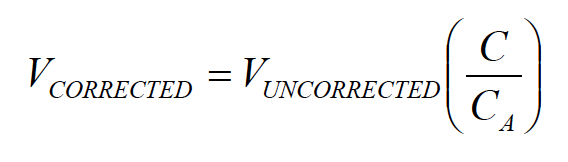

In [ ]:
df.beam1vel.values = correct_sound_speed(df.beam1vel, df.speedofsound, 1500)
df.beam2vel.values = correct_sound_speed(df.beam2vel, df.speedofsound, 1500)
df.beam3vel.values = correct_sound_speed(df.beam3vel, df.speedofsound, 1500)
df.beam4vel.values = correct_sound_speed(df.beam4vel, df.speedofsound, 1500)

In [ ]:
tot_ad2cp.beam1vel.values = correct_sound_speed(df.beam1vel, df.speedofsound, 1500)

## QAQC Step 2 & 3: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [ ]:
df.beam1vel.values, df.beam2vel.values, df.beam3vel.values, df.beam4vel.values = qaqc_pre_coord_transform(df.beam1vel,df.beam2vel,df.beam3vel,df.beam4vel,df.beam1amp,df.beam2amp,df.beam3amp,df.beam4amp,df.beam1cor,df.beam2cor,df.beam3cor,df.beam4cor,df.pitch)

# Processing Step 3: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

## Loop to actually bin map beam velocities

The function binmap_adcp() was written to work for a single ping so it needs to be run in a loop through every ping

In [ ]:
for x in np.arange(0,df.beam1vel.shape[1]):
    # Note the variable roll cannot be called with df.roll as roll() is a function that can be applied to a dataframe
    #     df.beam1vel.values[:,x] = binmap_adcp(df.beam1vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    #     df.beam2vel.values[:,x] = binmap_adcp(df.beam2vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    #     df.beam3vel.values[:,x] = binmap_adcp(df.beam3vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    #     df.beam4vel.values[:,x] = binmap_adcp(df.beam4vel[:,x],df.pitch[x],df['roll'][x],df.bins)
    df.beam1vel.values[:,x] = binmap_adcp(df.beam1vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 1)
    df.beam2vel.values[:,x] = binmap_adcp(df.beam2vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 2)
    df.beam3vel.values[:,x] = binmap_adcp(df.beam3vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 3)
    df.beam4vel.values[:,x] = binmap_adcp(df.beam4vel[:,x],df.pitch[x],df['roll'][x],df.bins, df.blanking[0], beam_number = 4)
    

### Take a peak at the bin mapped data

In [ ]:
[x,y]=np.meshgrid(df.time,df.bins)
[bdepth,bbins]=np.meshgrid(df.depth,df.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],df.beam1vel[:,12000:14000])
plt.plot(df.time[12000:14000],-df.depth[12000:14000],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 4: Convert from Beam to XYZ to ENU coordinates

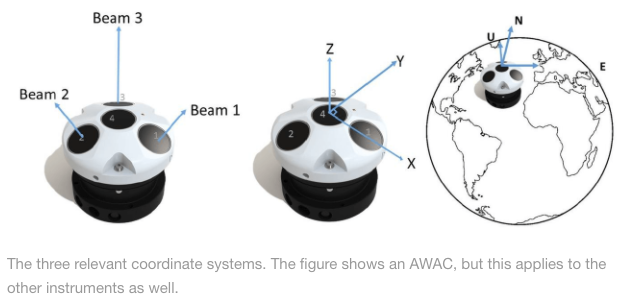

## Loop to actually convert beam to ENU velocity

The function beam2enu() was written to work for a single ping so it needs to be run in a loop through every ping

In [ ]:
# Initialize final variables with NaNs first
east             = np.empty([df.beam1vel.shape[0],df.beam1vel.shape[1]])
north            = np.empty([df.beam1vel.shape[0],df.beam1vel.shape[1]])
up               = np.empty([df.beam1vel.shape[0],df.beam1vel.shape[1]])
east[:]          = np.NaN
north[:]         = np.NaN
up[:]            = np.NaN

for k in np.arange(0,df.beam1vel.shape[1]):
        enu = beam2enu(df.beam1vel[:,k],df.beam2vel[:,k],df.beam3vel[:,k],df.beam4vel[:,k],df.beam2xyz.values,df.ahrs_rot_mat.values[k,:],df.pitch[k])

        east[:,k]          = enu[0,:]
        north[:,k]         = enu[1,:]
        up[:,k]            = enu[2,:]

### Take a peak at ENU data

In [ ]:
[x,y]=np.meshgrid(df.time,df.bins)
[bdepth,bbins]=np.meshgrid(df.depth,df.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],east[:,12000:14000])
plt.plot(df.time[12000:14000],-df.depth[12000:14000],'k')
plt.colorbar(label='East-West Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 5: QAQC Post-Coordinate Transformation
## Exclude cells that report velocities relative to the glider exceeding 0.5 m/s

In [ ]:
east[east>0.5]   = np.NaN
north[north>0.5] = np.NaN
up[up>0.5]       = np.NaN

# Processing Step 6: Run the inversion!

In [ ]:
O_ls, G_ls, bin_new = inversion(U=east.transpose(),V=north.transpose(),H=1000,dz=10,u_daverage=0,v_daverage=0,bins = df.bins, depth = df.depth)

In [ ]:
plt.plot(np.real(O_ls),bin_new,label='u - velocity')
plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
plt.ylim(1000,0)
plt.legend()

In [ ]:
np.real(O_ls)